<a href="https://colab.research.google.com/github/NitheshNayak/AnomalyDetection_in_Cyber_Physical_Systems/blob/main/Bot_IoT_Data_Detection_of_Adverserial_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bot-IoT-Data:Detection of Adverserial attack 

In [ ]:
#Mount the Folder from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# the official Cleverhans library (without future moudule)
!pip install git+https://github.com/cleverhans-lab/cleverhans.git
# !pip install git+https://github.com/CNOCycle/cleverhans.git@feature/tf2.x
# !pip install git+https://github.com/tensorflow/cleverhans/pull/1122

  Cloning https://github.com/cleverhans-lab/cleverhans.git to /tmp/pip-req-build-4g5i4roe
  Running command git clone -q https://github.com/cleverhans-lab/cleverhans.git /tmp/pip-req-build-4g5i4roe
     |████████████████████████████████| 154 kB 5.2 MB/s 
     |████████████████████████████████| 42 kB 870 kB/s 
  Created wheel for cleverhans: filename=cleverhans-4.0.0-py3-none-any.whl size=92423 sha256=fa246d4eb263601219173b049d27f6965be6295bca47c386ba70f1d9dde9a4b8
  Stored in directory: /tmp/pip-ephem-wheel-cache-3ql9w0yq/wheels/9b/85/fc/711535dc7ec7166b7a4fa93ac3294df0dcf383f1364af0e3d4
Successfully built cleverhans


In [ ]:
# Libraries
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

import itertools 
import imblearn
from os.path import exists
from collections import Counter
from imblearn.over_sampling import SMOTE

import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import tensorflow as tf # 2.7.0
from tensorflow import keras
from tensorflow.keras.models import load_model

import torch
import torch.nn as nn
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model

import cleverhans #4.0.0-242afd7ec8f9546baeb1168438446ce1
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

print("\nTensorflow Version: " + tf.__version__)

print("\nCleverhans Version: " + cleverhans.__version__)


Tensorflow Version: 2.8.0

Cleverhans Version: 4.0.0-242afd7ec8f9546baeb1168438446ce1


In [ ]:
# Printing GPU Information
print("GPU Available: ", tf.test.is_gpu_available())

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
Wed Feb 16 22:56:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    75W / 149W |    145MiB / 11441MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------

In [ ]:
## Confusion Matrix Plot Function : Function is defined here for later use

def plot_confusion_matrix(cm,classes
                          ,normalize=False,
                          title='Confusion Matrix',cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion Matrix without normalization")
        
    print(cm)
    
    thresh = cm.max() /2.
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i, cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted label')

# **Data Preprocessing**
## Load Data

In [ ]:
# Load the dataset
dataset = pd.read_csv("/content/drive/MyDrive/VRES/Bot-IoT-Training.csv") #path of the datafile 
dataset.dropna(inplace=True)

# Check the shape
print("Shape of the input file - ",dataset.shape)
print("\n")

# Print the first 5 lines of the dataset 
dataset.head(5)

Shape of the input file -  (2934817, 19)




,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,3142762,udp,192.168.100.150,6551,192.168.100.3,80,251984,1.900363,100,0.000000,4,2.687519,100,0.0,0.494549,4.031619,1,DDoS,UDP
1,2432264,tcp,192.168.100.150,5532,192.168.100.3,80,256724,0.078003,38,3.856930,3,3.934927,100,0.0,0.256493,4.012924,1,DDoS,TCP
2,1976315,tcp,192.168.100.147,27165,192.168.100.3,80,62921,0.268666,100,2.974100,3,3.341429,100,0.0,0.294880,3.609205,1,DDoS,TCP
3,1240757,udp,192.168.100.150,48719,192.168.100.3,80,99168,1.823185,63,0.000000,4,3.222832,63,0.0,0.461435,4.942302,1,DoS,UDP
4,3257991,udp,192.168.100.147,22461,192.168.100.3,80,105063,0.822418,100,2.979995,4,3.983222,100,0.0,1.002999,4.994452,1,DDoS,UDP


In [ ]:
# Information of the input data
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2934817 entries, 0 to 2934816
Data columns (total 19 columns):
 #   Column             Dtype  
---  ------             -----  
 0   pkSeqID            int64  
 1   proto              object 
 2   saddr              object 
 3   sport              object 
 4   daddr              object 
 5   dport              object 
 6   seq                int64  
 7   stddev             float64
 8   N_IN_Conn_P_SrcIP  int64  
 9   min                float64
 10  state_number       int64  
 11  mean               float64
 12  N_IN_Conn_P_DstIP  int64  
 13  drate              float64
 14  srate              float64
 15  max                float64
 16  attack             int64  
 17  category           object 
 18  subcategory        object 
dtypes: float64(6), int64(6), object(7)
memory usage: 447.8+ MB


In [ ]:
# Check for NUll Values 
dataset.isna().sum()

pkSeqID              0
proto                0
saddr                0
sport                0
daddr                0
dport                0
seq                  0
stddev               0
N_IN_Conn_P_SrcIP    0
min                  0
state_number         0
mean                 0
N_IN_Conn_P_DstIP    0
drate                0
srate                0
max                  0
attack               0
category             0
subcategory          0
dtype: int64

In [ ]:
# Check for Duplicates
print("There is no duplicate entires present in the dataset: ", dataset[dataset.duplicated()].shape[0]==0)

There is no duplicate entires present in the dataset:  True


## Feature Selection

In [ ]:
# Feature Selection : Deleted unused columns
dataset1 = dataset.copy()
dataset1.drop(dataset1.columns[[0, 1 , 2, 3, 4, 5, 17, 18]], axis = 1, inplace = True)
print("Shape of the input file - ", dataset1.shape)
print("\n")
print(dataset1.iloc[0])
df = pd.DataFrame(dataset1)
df.head(5)

Shape of the input file -  (2934817, 11)


seq                  251984.000000
stddev                    1.900363
N_IN_Conn_P_SrcIP       100.000000
min                       0.000000
state_number              4.000000
mean                      2.687519
N_IN_Conn_P_DstIP       100.000000
drate                     0.000000
srate                     0.494549
max                       4.031619
attack                    1.000000
Name: 0, dtype: float64


,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack
0,251984,1.900363,100,0.000000,4,2.687519,100,0.0,0.494549,4.031619,1
1,256724,0.078003,38,3.856930,3,3.934927,100,0.0,0.256493,4.012924,1
2,62921,0.268666,100,2.974100,3,3.341429,100,0.0,0.294880,3.609205,1
3,99168,1.823185,63,0.000000,4,3.222832,63,0.0,0.461435,4.942302,1
4,105063,0.822418,100,2.979995,4,3.983222,100,0.0,1.002999,4.994452,1


## Data preparation for model train and test

In [ ]:
# Separate lable column from the overall dataset
x = df.drop('attack',axis='columns')
y = df['attack']

# Check the classes in the dataset
counter = Counter(y)
print("Class split in the dataset -", counter)

Class split in the dataset - Counter({1: 2934447, 0: 370})


In [ ]:
# Data Balance
# smote = SMOTE(sampling_strategy='minority')
# train_samples, train_labels = smote.fit_resample(x,y)
# counter = Counter(train_labels)
# print("Class split in the dataset after balancing -", counter)

train_samples, train_labels = x, y #Without Databalance

In [ ]:
# Data Normalization (MinMax): scale data to make values between 0 and 1
scaler = MinMaxScaler().fit(train_samples)
scaled_x = scaler.transform(train_samples)
pd.DataFrame(scaled_x)

print("After Normalizing with MinMax \n")
print(scaled_x)

After Normalizing with MinMax 

[[9.60996911e-01 7.61130712e-01 1.00000000e+00 ... 0.00000000e+00
  4.94549000e-07 8.06323961e-01]
 [9.79074025e-01 3.12416517e-02 3.73737374e-01 ... 0.00000000e+00
  2.56493000e-07 8.02584961e-01]
 [2.39960337e-01 1.07605728e-01 1.00000000e+00 ... 0.00000000e+00
  2.94880000e-07 7.21841144e-01]
 ...
 [6.04915907e-01 8.45986583e-01 1.00000000e+00 ... 0.00000000e+00
  2.07444000e-07 8.66523173e-01]
 [6.85915869e-01 0.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  1.62130000e-07 0.00000000e+00]
 [3.63937302e-01 2.15559106e-02 1.00000000e+00 ... 6.59532023e-07
  1.16388000e-07 3.44816069e-02]]


In [ ]:
# Encoding the lables 
le = LabelEncoder()
y_encoded = le.fit_transform(train_labels)
y_encoded = np_utils.to_categorical(y_encoded)
print(y_encoded)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
# Data split for train and test with 70:30 split with stratified Sampling 
RANDOM_STATE = 42
TEST_SPLIT = 0.3
train_samples, test_samples, train_labels, test_labels = train_test_split(
    scaled_x, y_encoded, test_size=TEST_SPLIT, random_state=RANDOM_STATE, stratify=y_encoded)
print("Train Set: ", train_samples.shape, train_labels.shape)
print("Test Set: ", test_samples.shape, test_labels.shape)

Train Set:  (2054371, 10) (2054371, 2)
Test Set:  (880446, 10) (880446, 2)


### Save Processed Data

In [ ]:
# Save processed data using following code if needed
# train_samples_df = pd.DataFrame(train_samples)
# print(train_samples_df.shape)
# test_samples_df = pd.DataFrame(test_samples)
# print(test_samples_df.shape)

# train_labels_df = pd.DataFrame(train_labels)
# print(train_samples_df.shape)
# test_labels_df = pd.DataFrame(test_labels)
# print(test_labels_df.shape)
# for data in [
#              ["scaled_train_samples.csv", train_samples_df, train_samples.columns.values], 
#              ["train_labels.csv", train_labels_df, train_labels_df.columns.values], 
#              ["scaled_test_samples.csv", test_samples_df, test_samples.columns.values], 
#              ["test_labels.csv", test_labels_df, test_labels_df.columns.values]
#              ]:

#   path = "/content/drive/MyDrive/VRES/Epsilon/" + data[0]
#   if exists(path) == False:
#     data[1].to_csv(path, header=data[2], index=False)

### Read Saved CSV

In [ ]:
# scaled_train_samples = pd.read_csv("/content/drive/MyDrive/VRES/Epsilon/scaled_train_samples.csv")
# train_labels = pd.read_csv("/content/drive/MyDrive/VRES/Epsilon/train_labels.csv")
# scaled_test_samples = pd.read_csv("/content/drive/MyDrive/VRES/Epsilon/scaled_test_samples.csv")
# test_labels = pd.read_csv("/content/drive/MyDrive/VRES/Epsilon/test_labels.csv")

# **Model Architecture and Traning**

In [ ]:
# Model Architecture
model = keras.Sequential(
    [
     keras.layers.Input(shape=(10,)),
     keras.layers.Dense(20, activation='tanh'),
     keras.layers.Dense(60, activation='tanh'),
     keras.layers.Dense(80, activation='tanh'),
     keras.layers.Dense(90, activation='tanh'),
     keras.layers.Dense(2, activation='sigmoid') 
    ]
  )

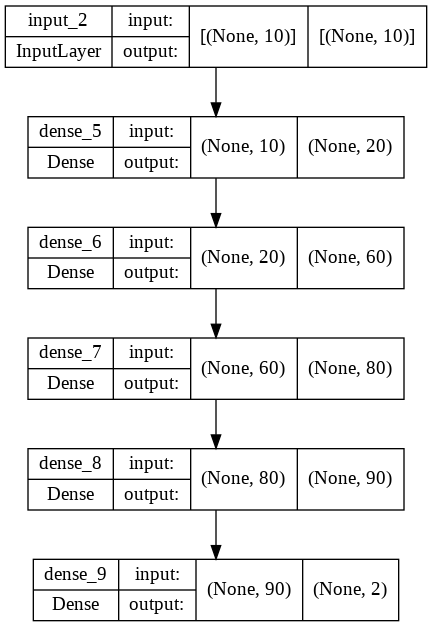

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Model summery
print(model.input_shape)
print(model.summary())

(None, 10)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 20)                220       
                                                                 
 dense_6 (Dense)             (None, 60)                1260      
                                                                 
 dense_7 (Dense)             (None, 80)                4880      
                                                                 
 dense_8 (Dense)             (None, 90)                7290      
                                                                 
 dense_9 (Dense)             (None, 2)                 182       
                                                                 
Total params: 13,832
Trainable params: 13,832
Non-trainable params: 0
_________________________________________________________________
None


## Model Parameters

In [ ]:
# Model hyperparameters
BATCH_SIZE = 32
EPOCH = 3
VERBOSE = 1
VALIDATION_SPLIT = 0.4
RANDOM_STATE = 42
LEARNING_RATE = 0.001 #0.01
MODEL_PATH = "/content/drive/MyDrive/VRES/Bot_IoT/model_botIoT.h5"

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy']) 

In [ ]:
# Train the model 
model.fit(x=train_samples, y=train_labels, batch_size=BATCH_SIZE, epochs=EPOCH, 
          verbose=VERBOSE, validation_split=VALIDATION_SPLIT, shuffle=True)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


77030/77030 [==============================] - 434s 6ms/step - loss: 0.0381 - accuracy: 0.9904 - val_loss: 0.0167 - val_accuracy: 0.9961
Epoch 2/3
77030/77030 [==============================] - 462s 6ms/step - loss: 0.0153 - accuracy: 0.9963 - val_loss: 0.0141 - val_accuracy: 0.9966
Epoch 3/3
77030/77030 [==============================] - 434s 6ms/step - loss: 0.0133 - accuracy: 0.9967 - val_loss: 0.0125 - val_accuracy: 0.9969


In [ ]:
# Save the model 
if exists(MODEL_PATH) == False:
  model.save(MODEL_PATH)

## Model Predictions

Model Evaluation: 
55021/55021 [==============================] - 166s 3ms/step - loss: 0.0123 - accuracy: 0.9969
[0.012301326729357243, 0.9969154000282288]


Model Prediction...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    880334
           1       1.00      0.99      1.00    880335

   micro avg       1.00      1.00      1.00   1760669
   macro avg       1.00      1.00      1.00   1760669
weighted avg       1.00      1.00      1.00   1760669
 samples avg       1.00      1.00      1.00   1760669

Confusion Matrix without normalization
[[879781    553]
 [  4940 875395]]


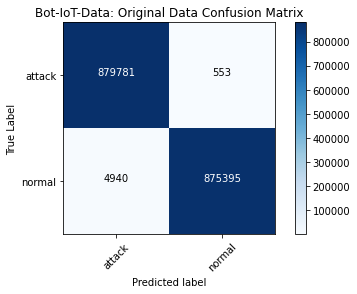

In [ ]:
# Model prediction 
print("Model Evaluation: ")
print(model.evaluate(test_samples, test_labels))
print("\n")

print("Model Prediction...")
pred_Main1 = model.predict(test_samples)
pred_Main = np.round(pred_Main1)
print("Classification Report: \n",classification_report(test_labels, pred_Main))

cm = confusion_matrix(test_labels.argmax(axis=1), pred_Main.argmax(axis=1))
CM_PLOT_LABLES = ['attack','normal'] # Confusion matrix lables defined here
plot_confusion_matrix(cm=cm, classes=CM_PLOT_LABLES, title="Bot-IoT-Data: Original Data Confusion Matrix")

# **FGSM and Prediction**

In [ ]:
# Load the Model: Load model when we need to use it after restarting runtime. 
# model = load_model("/content/drive/MyDrive/VRES/Bot_IoT/model_botIoT.h5")

CM_PLOT_LABLES = ['attack','normal'] # Class lables for Confusion Matix

# Create a list for saving accuracy
adv_acc = []

# Check model shape
model.layers[-1].output
model.input

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'input_1')>

In [ ]:
# Logits Model as given in - https://arxiv.org/abs/2104.12426
logits_model = tf.keras.Model(model.input, model.layers[-1].output)
logits_model

In [ ]:
# Convert the Test samples to tensor
original_data = test_samples.copy()
original_data = tf.convert_to_tensor(original_data.reshape((len(test_samples), 10)))
original_data

<tf.Tensor: shape=(1760669, 10), dtype=float64, numpy=
array([[1.63380497e-02, 0.00000000e+00, 1.61616162e-01, ...,
        0.00000000e+00, 3.10981700e-07, 0.00000000e+00],
       [5.30910339e-02, 0.00000000e+00, 1.31313131e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.20000024e-05],
       [5.72060562e-05, 4.97769144e-01, 2.52525253e-01, ...,
        1.50137229e-05, 8.83161064e-07, 9.99997661e-01],
       ...,
       [8.76572213e-01, 6.82825723e-01, 5.45454545e-01, ...,
        0.00000000e+00, 2.79177000e-07, 9.20785784e-01],
       [6.74280157e-01, 2.28698919e-01, 7.87878788e-01, ...,
        0.00000000e+00, 3.23973000e-07, 9.32746587e-01],
       [1.41070135e-02, 0.00000000e+00, 7.37373737e-01, ...,
        0.00000000e+00, 0.00000000e+00, 6.82888129e-03]])>

Model Evaluation : 
55021/55021 [==============================] - 164s 3ms/step - loss: 0.0123 - accuracy: 0.9969
[0.012301326729357243, 0.9969154000282288]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    880334
           1       1.00      0.99      1.00    880335

   micro avg       1.00      1.00      1.00   1760669
   macro avg       1.00      1.00      1.00   1760669
weighted avg       1.00      1.00      1.00   1760669
 samples avg       1.00      1.00      1.00   1760669

Confusion Matrix without normalization
[[879781    553]
 [  4940 875395]]


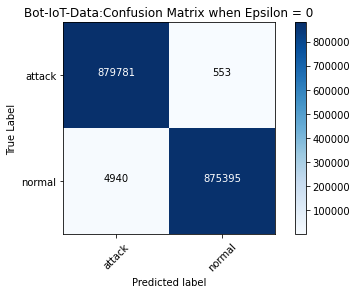

In [ ]:
# fast_gradient_method with varing Epsilon value 

# Epsilon value: EPS
EPS= 0 

# Generate adversarial samples
adv_data_0 = fast_gradient_method(logits_model, original_data, EPS, np.inf, targeted=False)

print("Model Evaluation : ")
print(model.evaluate(adv_data_0, test_labels))

pred0 = model.predict(adv_data_0)
pred0 = np.round(pred0)
print("Classification Report: \n", classification_report(test_labels, pred0))

# The confusion matrix
cm0 = confusion_matrix(test_labels.argmax(axis=1), pred0.argmax(axis=1))
plot_confusion_matrix(cm=cm0, classes=CM_PLOT_LABLES, title="Bot-IoT-Data:Confusion Matrix when Epsilon = 0")

In [ ]:
adv_acc.append(accuracy_score(test_labels, pred0)) # Saving the prediction accuracy



---



---



Model Evaluation : 
55021/55021 [==============================] - 162s 3ms/step - loss: 5.0559 - accuracy: 0.4316
[5.0559234619140625, 0.43158140778541565]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00    880334
           1       0.46      0.86      0.60    880335

   micro avg       0.43      0.43      0.43   1760669
   macro avg       0.23      0.43      0.30   1760669
weighted avg       0.23      0.43      0.30   1760669
 samples avg       0.43      0.43      0.43   1760669

Confusion Matrix without normalization
[[   555 879779]
 [122099 758236]]


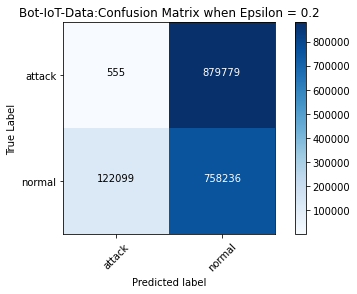

In [ ]:
# fast_gradient_method with varing Epsilon value 

# Epsilon value: EPS
EPS= 0.2

# Generate adversarial samples
adv_data_1 = fast_gradient_method(logits_model, original_data, EPS, np.inf, targeted=False)

print("Model Evaluation : ")
print(model.evaluate(adv_data_1, test_labels))

pred1 = model.predict(adv_data_1)
pred1 = np.round(pred1)
print("Classification Report: \n", classification_report(test_labels, pred1))

# The confusion matrix
cm1 = confusion_matrix(test_labels.argmax(axis=1), pred1.argmax(axis=1))
plot_confusion_matrix(cm=cm1, classes=CM_PLOT_LABLES, title="Bot-IoT-Data:Confusion Matrix when Epsilon = 0.2")

In [ ]:
adv_acc.append(accuracy_score(test_labels, pred1))



---



---



Model Evaluation : 
55021/55021 [==============================] - 164s 3ms/step - loss: 8.7172 - accuracy: 0.1283
[8.717207908630371, 0.12825125455856323]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00    880334
           1       0.20      0.25      0.22    880335

   micro avg       0.13      0.13      0.13   1760669
   macro avg       0.10      0.13      0.11   1760669
weighted avg       0.10      0.13      0.11   1760669
 samples avg       0.13      0.13      0.13   1760669

Confusion Matrix without normalization
[[   555 879779]
 [658078 222257]]


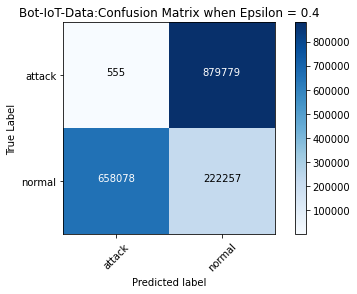

In [ ]:
# fast_gradient_method with varing Epsilon value 

# Epsilon value: EPS
EPS= 0.4

# Generate adversarial samples
adv_data_2 = fast_gradient_method(logits_model, original_data, EPS, np.inf, targeted=False)

print("Model Evaluation : ")
print(model.evaluate(adv_data_2, test_labels))

pred2 = model.predict(adv_data_2)
pred2 = np.round(pred2)
print("Classification Report: \n", classification_report(test_labels, pred2))

# The confusion matrix
cm2 = confusion_matrix(test_labels.argmax(axis=1), pred2.argmax(axis=1))
plot_confusion_matrix(cm=cm2, classes=CM_PLOT_LABLES, title="Bot-IoT-Data:Confusion Matrix when Epsilon = 0.4")

In [ ]:
adv_acc.append(accuracy_score(test_labels, pred2))



---



---



Model Evaluation : 
55021/55021 [==============================] - 161s 3ms/step - loss: 11.3892 - accuracy: 0.0031
[11.38919448852539, 0.003084623022004962]
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00    880334
           1       0.01      0.01      0.01    880335

   micro avg       0.00      0.00      0.00   1760669
   macro avg       0.00      0.00      0.00   1760669
weighted avg       0.00      0.00      0.00   1760669
 samples avg       0.00      0.00      0.00   1760669

Confusion Matrix without normalization
[[   555 879779]
 [875459   4876]]


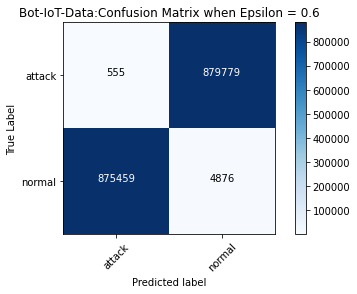

In [ ]:
# fast_gradient_method with varing Epsilon value 

# Epsilon value: EPS
EPS= 0.6

# Generate adversarial samples
adv_data_3 = fast_gradient_method(logits_model, original_data, EPS, np.inf, targeted=False)

print("Model Evaluation : ")
print(model.evaluate(adv_data_3, test_labels))

pred3 = model.predict(adv_data_3)
pred3 = np.round(pred3)
print("Classification Report: \n", classification_report(test_labels, pred3))

# The confusion matrix
cm3 = confusion_matrix(test_labels.argmax(axis=1), pred3.argmax(axis=1))
plot_confusion_matrix(cm=cm3, classes=CM_PLOT_LABLES, title="Bot-IoT-Data:Confusion Matrix when Epsilon = 0.6")

In [ ]:
adv_acc.append(accuracy_score(test_labels, pred3))



---



---



Model Evaluation : 
55021/55021 [==============================] - 160s 3ms/step - loss: 11.8604 - accuracy: 0.0031
[11.860371589660645, 0.003084623022004962]
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00    880334
           1       0.01      0.01      0.01    880335

   micro avg       0.00      0.00      0.00   1760669
   macro avg       0.00      0.00      0.00   1760669
weighted avg       0.00      0.00      0.00   1760669
 samples avg       0.00      0.00      0.00   1760669

Confusion Matrix without normalization
[[   555 879779]
 [875459   4876]]


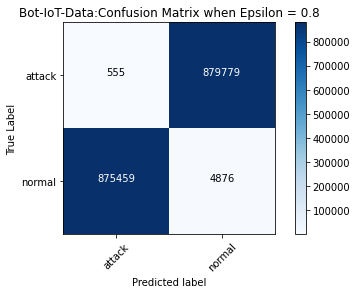

In [ ]:
# fast_gradient_method with varing Epsilon value 

# Epsilon value: EPS
EPS= 0.8

# Generate adversarial samples
adv_data_4 = fast_gradient_method(logits_model, original_data, EPS, np.inf, targeted=False)

print("Model Evaluation : ")
print(model.evaluate(adv_data_4, test_labels))

pred4 = model.predict(adv_data_4)
pred4 = np.round(pred4)
print("Classification Report: \n", classification_report(test_labels, pred4))

# The confusion matrix
cm4 = confusion_matrix(test_labels.argmax(axis=1), pred4.argmax(axis=1))
plot_confusion_matrix(cm=cm4, classes=CM_PLOT_LABLES, title="Bot-IoT-Data:Confusion Matrix when Epsilon = 0.8")

In [ ]:
adv_acc.append(accuracy_score(test_labels, pred4))



---



---



Model Evaluation : 
55021/55021 [==============================] - 165s 3ms/step - loss: 11.9730 - accuracy: 0.0031
[11.973029136657715, 0.003084623022004962]
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00    880334
           1       0.01      0.01      0.01    880335

   micro avg       0.00      0.00      0.00   1760669
   macro avg       0.00      0.00      0.00   1760669
weighted avg       0.00      0.00      0.00   1760669
 samples avg       0.00      0.00      0.00   1760669

Confusion Matrix without normalization
[[   555 879779]
 [875459   4876]]


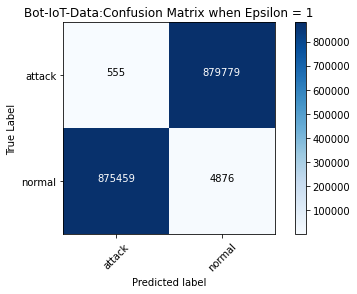

In [ ]:
# fast_gradient_method with varing Epsilon value 

# Epsilon value: EPS
EPS = 1

# Generate adversarial samples
adv_data_5 = fast_gradient_method(logits_model, original_data, EPS, np.inf, targeted=False)

print("Model Evaluation : ")
print(model.evaluate(adv_data_5, test_labels))

pred5 = model.predict(adv_data_5)
pred5 = np.round(pred5)
print("Classification Report: \n", classification_report(test_labels, pred5))

# The confusion matrix
cm5 = confusion_matrix(test_labels.argmax(axis=1), pred5.argmax(axis=1))
plot_confusion_matrix(cm=cm5, classes=CM_PLOT_LABLES, title="Bot-IoT-Data:Confusion Matrix when Epsilon = 1")

In [ ]:
adv_acc.append(accuracy_score(test_labels, pred5))

# **Epsilon Value VS. Accuracy**

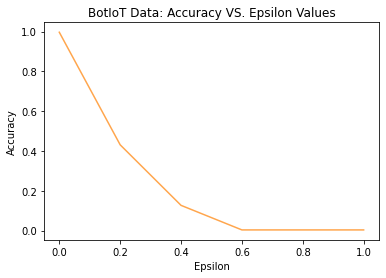

In [ ]:
# Epsilon value VS. Accuracy
plt.plot(np.linspace(0, 1, 6, True), adv_acc, color='#ffa64d')
plt.title('BotIoT Data: Accuracy VS. Epsilon Values')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.show()

# Retrain Model with Adverserial Samples
Retrain model with samples including various percentage of adversarial samples.

## Experiment 1

We have 70% for training and 30% for testing. Now we are going to split the 70% into 60% and 10%, and use the 10% to generate adversarial samples. 

In [ ]:
# Retain from "FGSM and Prediction"
CM_PLOT_LABLES = ['attack','normal'] # Class lables for Confusion Matix

In [ ]:
# Logits Model as given in - https://arxiv.org/abs/2104.12426
logits_model = tf.keras.Model(model.input, model.layers[-1].output)
logits_model

In [ ]:
# Parameters
EPS = 1 #Epsilon Value
RANDOM_STATE = 42
TRAIN_ADVERSERIAL_SIZE = 0.1
TEST_ADVERSERIAL_SIZE = 0.5

# Adding adverserial samples to train set 

norm_samples1, adv_samples1, norm_labels1, adv_labels1 = train_test_split(
    train_samples, train_labels, test_size=TRAIN_ADVERSERIAL_SIZE, 
    random_state=RANDOM_STATE, stratify=train_labels) # Making the train and adverserial sample split 

original_data = adv_samples1.copy()
original_data = tf.convert_to_tensor(original_data.reshape((len(adv_samples1), 10))) # Convert to part of train samples to tensor

adv_samples1 = fast_gradient_method(logits_model, original_data,EPS, np.inf) # Run fast_gradient_method on the tensor train sample 

# Concatenate split train data
exp_train_samples1 = tf.concat((norm_samples1, adv_samples1), 0)
exp_train_labels1 = np.concatenate((norm_labels1, adv_labels1), axis=0)
exp_train_samples1 = exp_train_samples1.numpy()

# # Shuffle train data
exp_train_samples1, exp_train_labels1 = shuffle(exp_train_samples1, exp_train_labels1, random_state=RANDOM_STATE)

# # Add Adverserial Samples to testing set 
# original_data = test_samples.copy()
# original_data = tf.convert_to_tensor(original_data.reshape((len(test_samples), 10)))

# # 
# norm_samples, adv_samples, norm_labels, adv_labels = train_test_split(
#     test_samples, test_labels, test_size=TEST_ADVERSERIAL_SIZE, 
#     random_state=RANDOM_STATE, stratify=test_labels) # Making the train and adverserial sample split 

# original_data = adv_samples.copy()
# original_data = tf.convert_to_tensor(original_data.reshape((len(adv_samples), 10))) # Convert to part of test samples to tensor

# adv_samples1 = fast_gradient_method(logits_model, original_data, EPS, np.inf) # Run fast_gradient_method on the tensor test sample 

# # Concatenate split test data
# exp_test_samples = tf.concat((norm_samples, adv_samples), 0)
# exp_test_labels = tf.concat((norm_labels, adv_labels), 0)
# exp_test_samples = exp_test_samples.numpy() # Convert to numpy for shuffling 
# exp_test_labels = exp_test_labels.numpy()

# # Shuffle test data
# exp_test_samples, exp_test_labels = shuffle(exp_test_samples, exp_test_labels, random_state=RANDOM_STATE)


# Add Adverserial Samples to testing set 
original_data = test_samples.copy()
original_data = tf.convert_to_tensor(original_data.reshape((len(test_samples), 10)))

# 
adv_samples, adv_labels = test_samples, test_labels # Making the train and adverserial sample split 

original_data = adv_samples.copy()
original_data = tf.convert_to_tensor(original_data.reshape((len(adv_samples), 10))) # Convert to part of test samples to tensor

adv_samples11 = fast_gradient_method(logits_model, original_data, EPS, np.inf) # Run fast_gradient_method on the tensor test sample 

# Concatenate split test data

exp_test_samples = adv_samples11.numpy() # Convert to numpy for shuffling 
exp_test_labels = adv_labels.copy()

# Shuffle test data
exp_test_samples, exp_test_labels = shuffle(exp_test_samples, exp_test_labels, random_state=RANDOM_STATE)


In [ ]:
# Convert test and train samples to tensor
exp_train_samples1 = tf.convert_to_tensor(exp_train_samples1)
exp_test_samples1 = tf.convert_to_tensor(exp_test_samples)

print("Train Samples - ", exp_train_samples1.shape, exp_train_labels1.shape)
print("Test Samples - ", exp_test_samples1.shape, exp_test_labels.shape)

Train Samples -  (2054371, 10) (2054371, 2)
Test Samples -  (880446, 10) (880446, 2)


In [ ]:
# Model training
# Model hyperparameters
BATCH_SIZE = 32
EPOCH = 3
VERBOSE = 1
VALIDATION_SPLIT = 0.4

model.fit(x=exp_train_samples1, y=exp_train_labels1, batch_size=BATCH_SIZE, epochs=EPOCH, 
          verbose=1, validation_split=VALIDATION_SPLIT, shuffle=True)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


38520/38520 [==============================] - 211s 5ms/step - loss: 0.0120 - accuracy: 0.9992 - val_loss: 0.0015 - val_accuracy: 0.9999
Epoch 2/3
38520/38520 [==============================] - 237s 6ms/step - loss: 0.0013 - accuracy: 0.9999 - val_loss: 0.0011 - val_accuracy: 0.9999
Epoch 3/3
38520/38520 [==============================] - 212s 6ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.0010 - val_accuracy: 0.9999


Model Evaluation .. 
27514/27514 [==============================] - 82s 3ms/step - loss: 0.0012 - accuracy: 0.9999
[0.0012116810539737344, 0.9998739361763]
Model Prediction....


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       111
           1       1.00      1.00      1.00    880335

   micro avg       1.00      1.00      1.00    880446
   macro avg       0.50      0.50      0.50    880446
weighted avg       1.00      1.00      1.00    880446
 samples avg       1.00      1.00      1.00    880446

Confusion Matrix without normalization
[[     0    111]
 [     0 880335]]


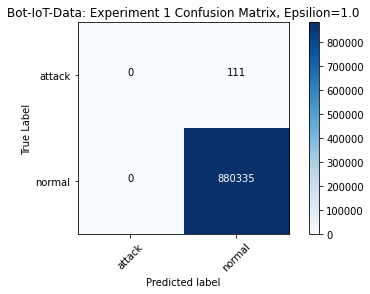

In [ ]:
# Predict after fitting mixed data to the model
print("Model Evaluation .. ")
print(model.evaluate(exp_test_samples1, exp_test_labels))

print("Model Prediction....")
exp_pred1 = model.predict(exp_test_samples1)
exp_pred1 = np.round(exp_pred1)

print("Classification Report: \n",classification_report(exp_test_labels, exp_pred1))
exp1= confusion_matrix(exp_test_labels.argmax(axis=1), exp_pred1.argmax(axis=1))
plot_confusion_matrix(cm=exp1, classes=CM_PLOT_LABLES, title="Bot-IoT-Data: Experiment 1 Confusion Matrix, Epsilion=1.0")

## Experiment 2

In [ ]:
# Retain from "FGSM and Prediction"
CM_PLOT_LABLES = ['attack','normal'] # Class lables for Confusion Matix

In [ ]:
# Logits Model as given in - https://arxiv.org/abs/2104.12426
logits_model = tf.keras.Model(model.input, model.layers[-1].output)
logits_model

In [ ]:
# Parameters

EPS = 1 # Epsilon Value
RANDOM_STATE = 42
TRAIN_ADVERSERIAL_SIZE = 0.2
TEST_ADVERSERIAL_SIZE = 0.5

# Adding Adverserial Samples to train set 

norm_samples, adv_samples2, norm_labels, adv_labels2 = train_test_split(
    train_samples, train_labels, test_size=TRAIN_ADVERSERIAL_SIZE, 
    random_state=RANDOM_STATE, stratify=train_labels) # Making the train and adverserial sample split 

original_data = adv_samples2.copy()
original_data = tf.convert_to_tensor(original_data.reshape((len(adv_samples2), 10))) #Convert to part of train samples to tensor

adv_samples2 = fast_gradient_method(logits_model, original_data,EPS, np.inf) # Run fast_gradient_method on the tensor train sample 

# Concatenate split train data
exp_train_samples2 = tf.concat((norm_samples, adv_samples2), 0)
exp_train_labels2 = np.concatenate((norm_labels, adv_labels2), axis=0)
exp_train_samples2 = exp_train_samples2.numpy()

# Shuffle train data
exp_train_samples2, exp_train_labels2 = shuffle(exp_train_samples2, exp_train_labels2, random_state=RANDOM_STATE)

# We have kept the test size split same as experiment 1 

# # Add Adverserial Samples to test set 
# norm_samples, adv_samples, norm_labels, adv_labels = train_test_split(
#     test_samples, test_labels, test_size=TEST_ADVERSERIAL_SIZE, 
#     random_state=RANDOM_STATE, stratify=test_labels) # Making the train and adverserial sample split 

# original_data = adv_samples.copy()
# original_data = tf.convert_to_tensor(original_data.reshape((len(adv_samples), 10))) # Convert to part of test samples to tensor

# adv_samples1 = fast_gradient_method(logits_model, original_data, EPS, np.inf) # Run fast_gradient_method on the tensor test sample 

# # Concatenate split test data
# exp_test_samples = tf.concat((norm_samples, adv_samples), 0)
# exp_test_labels = tf.concat((norm_labels, adv_labels), 0)
# exp_test_samples = exp_test_samples.numpy() # Convert to numpy for shuffling 
# exp_test_labels = exp_test_labels.numpy()

# # Shuffle test data
# exp_test_samples, exp_test_labels = shuffle(exp_test_samples, 
#                                             exp_test_labels, random_state=RANDOM_STATE)

# Add Adverserial Samples to test set 
adv_samples, adv_labels = test_samples, test_labels # Making the train and adverserial sample split 

original_data = adv_samples.copy()
original_data = tf.convert_to_tensor(original_data.reshape((len(adv_samples), 10))) # Convert to part of test samples to tensor

adv_samples21 = fast_gradient_method(logits_model, original_data, EPS, np.inf) # Run fast_gradient_method on the tensor test sample 

# Concatenate split test data
exp_test_samples = adv_samples21.numpy() # Convert to numpy for shuffling 
exp_test_labels = adv_labels.copy()

# Shuffle test data
exp_test_samples, exp_test_labels = shuffle(exp_test_samples, 
                                            exp_test_labels, random_state=RANDOM_STATE)

In [ ]:
# Convert test and train samples to tensor
exp_train_samples2 = tf.convert_to_tensor(exp_train_samples2)
exp_test_samples2 = tf.convert_to_tensor(exp_test_samples)

print("Train Samples - ", exp_train_samples2.shape, exp_train_labels2.shape)
print("Test Samples - ", exp_test_samples2.shape, exp_test_labels.shape)

Train Samples -  (4108225, 10) (4108225, 2)
Test Samples -  (1760669, 10) (1760669, 2)


In [ ]:
# Model training
# Model hyperparameters
BATCH_SIZE = 32
EPOCH = 3
VERBOSE = 1
VALIDATION_SPLIT = 0.4

model.fit(x=exp_train_samples2, y=exp_train_labels2, batch_size=BATCH_SIZE, epochs=EPOCH, 
          verbose=VERBOSE, validation_split=VALIDATION_SPLIT, shuffle=True)

Epoch 1/3
77028/77030 [============================>.] - ETA: 0s - loss: 0.0507 - accuracy: 0.9885

KeyboardInterrupt: ignored

In [ ]:
# Predict after fitting mixed data to the model
print("Model Evaluation")
print(model.evaluate(exp_test_samples2, exp_test_labels))

print("Model Prediction...")
exp_pred2 = model.predict(exp_test_samples2)
exp_pred2 = np.round(exp_pred2)

print("Classification Report: \n",classification_report(exp_test_labels, exp_pred2))
exp2= confusion_matrix(exp_test_labels.argmax(axis=1), exp_pred2.argmax(axis=1))
plot_confusion_matrix(cm=exp2, classes=CM_PLOT_LABLES, title="Bot-IoT-Data: Experiment 2 Confusion Matrix, Epsilion=1.0")